## Задание 3. 

Используйте Keras для обучения классификатора на сети MNIST. При этом:

* Обратите внимание, что в keras заложены типовые датасеты, включая MNIST. Для обращения к нему достаточно пары строчек кода (см, например, тут)
* Попробуйте несколько конфигураций сети с несколькими полносвязными слоями, передаточными функциями, и разным количеством нейронов

Подключение необходимых библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import shutil

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, losses

In [2]:
if os.path.isdir('graphics'):
  shutil.rmtree('graphics')

if os.path.exists('graphics.zip'):
  !rm graphics.zip

Функция построения графика точности и ошибок в процессе обучения модели нейронной сети

In [3]:
def plot_train_history(history, layers_str: [], epochs: int, batch_size: int, 
                       learning_rate: float, optimizer_name: str, loss_function_name: str, 
                       db_name: str, img_dir: str, df: pd.DataFrame):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)
  plt.figure(figsize=(16, 12))

  plt.subplot(2, 2, 1)
  plt.xlabel('Epochs')
  plt.ylabel('Accurancy')
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylim((0, 1))
  plt.grid(True, linestyle='--')
  plt.title('Training and Validation Accuracy')


  max_loss = max(loss)
  if max_loss < max(val_loss):
    max_loss = max(val_loss)
  
  ax = plt.subplot(2, 2, 3)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.ylim((0, max_loss + 0.1))
  plt.legend(loc='upper right')
  plt.grid(True, linestyle='--')
  plt.title('Training and Validation Loss')

  layers = "\n ".join(layers_str)
  description = f'Database: {db_name} \
    \nLayers (Activation Funcs): {layers} \
    \nEpochs: {epochs} \
    \nBatch Size: {batch_size} \
    \nOptimizer: {optimizer_name} \
    \nLearning Rate: {learning_rate}\
    \nLoss Function: {loss_function_name}\
    \nFinal Train Loss: {loss[-1]:.3f}\
    \nFinal Train Accuracy: {(acc[-1]*100):.2f}%\
    \nFinal Valid Loss: {val_loss[-1]:.3f}\
    \nFinal Valid Accuracy: {(val_acc[-1]*100):.2f}%'

  df.loc[df.shape[0]] = [epochs, batch_size, ' '.join(layers_str), optimizer_name, 
                         learning_rate, loss_function_name, f'{(acc[-1]*100):.2f}%',
                         f'{(val_acc[-1]*100):.2f}%', f'{loss[-1]:.3f}', f'{val_loss[-1]:.3f}']

  img_name = f'NN Training MNIST. Epochs({epochs}) Optim({optimizer_name}) LearningRate({learning_rate}) LossFunc({loss_function_name}) {df.shape[0]}.png'
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  plt.text(x=1.3, y=1.0, s=description, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

  if not os.path.isdir(img_dir):
    os.mkdir(img_dir)
  plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
  plt.show()

  return description

Настройка глобавльных переменных и загрузка датасета **MNIST**

In [4]:
ALL_HISTORY = pd.DataFrame(columns=['Epoches', 'Batch Size', 'Layers', 'Optimizer', 
                                    'Learning Rate', 'Loss Function', 'Final Train Accuracy',
                                    'Final Valid Accuracy', 'Final Train Loss', 'Final Valid Loss'])
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

- Нормировка значений пикселей
- изменение размерности массива, чтобы данные имели размерность `(n, w, h, с)`, где:
 
 - `n` - количество картинок 
 - `w` - количество пикселей в ширину
 - `h` - количество пикселей в высоту
 - `с` - количество цветовых каналов


In [5]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Выполнение процедуры `one hot encoding` для вектора ответов

In [6]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Построение модели

In [7]:
model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(Flatten())
model.add(Dense(28*28, activation='tanh'))
model.add(Dense(14*14, activation='sigmoid'))
model.add(Dense(7*7, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 196)               153860    
_________________________________________________________________
dense_2 (Dense)              (None, 49)                9653      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                500       
Total params: 779,453
Trainable params: 779,453
Non-trainable params: 0
_________________________________________________________________


In [8]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)

Epoch 1/15
329/329 [==============================] - 6s 18ms/step - loss: 0.3826 - accuracy: 0.8916 - val_loss: 0.2106 - val_accuracy: 0.9362
Epoch 2/15
329/329 [==============================] - 6s 17ms/step - loss: 0.1653 - accuracy: 0.9505 - val_loss: 0.1593 - val_accuracy: 0.9527
Epoch 3/15
329/329 [==============================] - 5s 17ms/step - loss: 0.1147 - accuracy: 0.9652 - val_loss: 0.1358 - val_accuracy: 0.9596
Epoch 4/15
329/329 [==============================] - 6s 17ms/step - loss: 0.0844 - accuracy: 0.9749 - val_loss: 0.1135 - val_accuracy: 0.9663
Epoch 5/15
329/329 [==============================] - 6s 17ms/step - loss: 0.0654 - accuracy: 0.9799 - val_loss: 0.1028 - val_accuracy: 0.9684
Epoch 6/15
329/329 [==============================] - 6s 17ms/step - loss: 0.0465 - accuracy: 0.9864 - val_loss: 0.0956 - val_accuracy: 0.9723
Epoch 7/15
329/329 [==============================] - 6s 17ms/step - loss: 0.0359 - accuracy: 0.9890 - val_loss: 0.0943 - val_accuracy: 0.9726

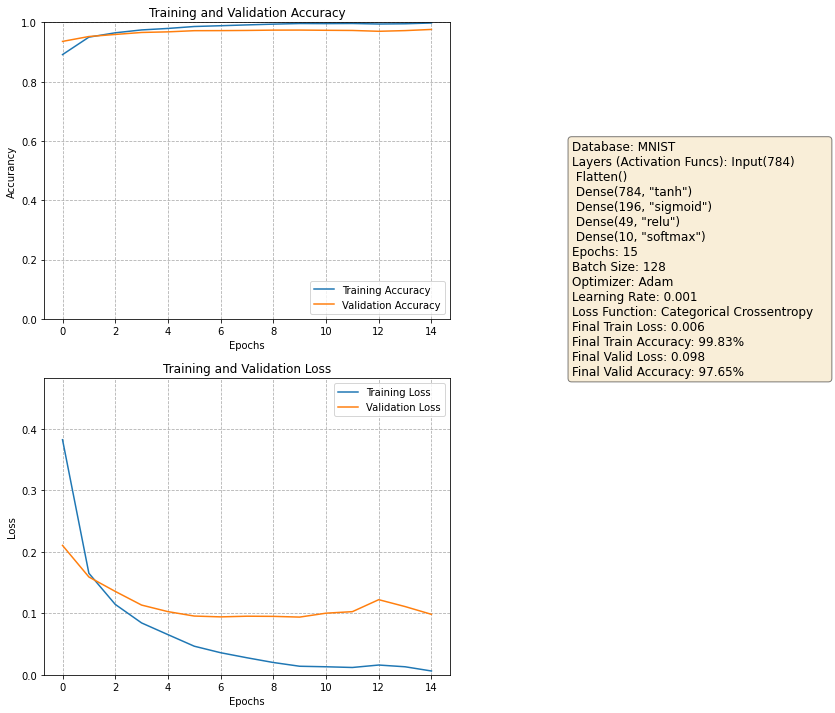

Database: MNIST     
Layers (Activation Funcs): Input(784)
 Flatten()
 Dense(784, "tanh")
 Dense(196, "sigmoid")
 Dense(49, "relu")
 Dense(10, "softmax")     
Epochs: 15     
Batch Size: 128     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Categorical Crossentropy    
Final Train Loss: 0.006    
Final Train Accuracy: 99.83%    
Final Valid Loss: 0.098    
Final Valid Accuracy: 97.65%


In [9]:
layers=[f'Input({28*28})', f'Flatten()', f'Dense({28*28}, "tanh")', f'Dense({14*14}, "sigmoid")', f'Dense({7*7}, "relu")', f'Dense({num_classes}, "softmax")']
print(plot_train_history(history, layers, epochs=epochs, batch_size=batch_size,
                         learning_rate=0.001, optimizer_name='Adam', loss_function_name='Categorical Crossentropy', 
                         db_name='MNIST', img_dir='graphics', df=ALL_HISTORY))

In [10]:
model = Sequential()
model.add(InputLayer(input_shape=(input_shape)))
model.add(Flatten())
model.add(Dense(28*28, activation='relu'))
model.add(Dense(14*14, activation='relu'))
model.add(Dense(7*7, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3, verbose=0)

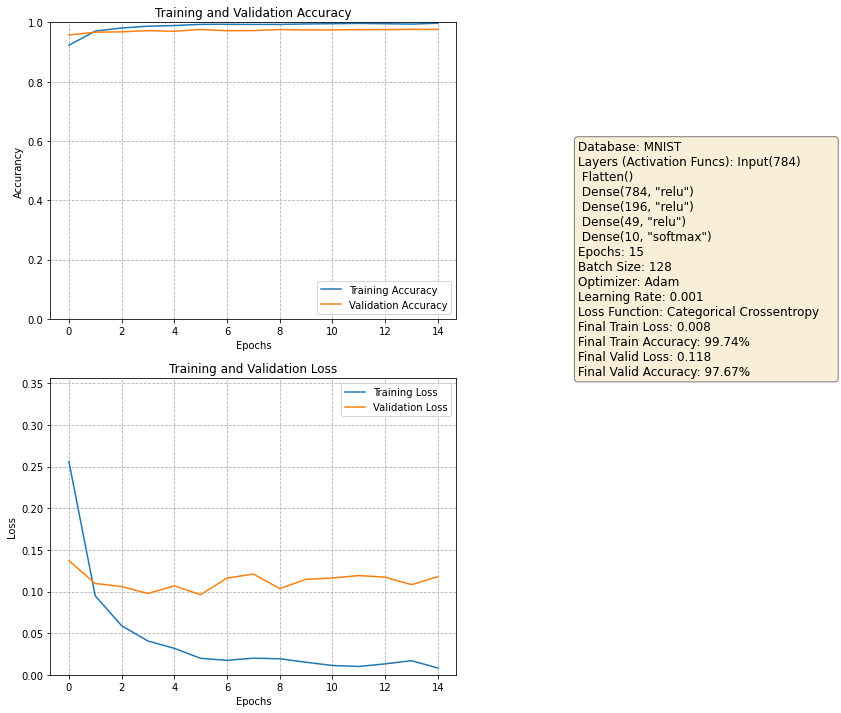

Database: MNIST     
Layers (Activation Funcs): Input(784)
 Flatten()
 Dense(784, "relu")
 Dense(196, "relu")
 Dense(49, "relu")
 Dense(10, "softmax")     
Epochs: 15     
Batch Size: 128     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Categorical Crossentropy    
Final Train Loss: 0.008    
Final Train Accuracy: 99.74%    
Final Valid Loss: 0.118    
Final Valid Accuracy: 97.67%


In [11]:
layers=[f'Input({28*28})', f'Flatten()\n Dense({28*28}, "relu")', f'Dense({14*14}, "relu")', f'Dense({7*7}, "relu")', f'Dense({num_classes}, "softmax")']
print(plot_train_history(history, layers, epochs=epochs, batch_size=batch_size, 
                         learning_rate=0.001, optimizer_name='Adam', loss_function_name='Categorical Crossentropy', 
                         db_name='MNIST', img_dir='graphics', df=ALL_HISTORY))

In [12]:
model = Sequential()
model.add(InputLayer(input_shape=(input_shape)))
model.add(Flatten())
model.add(Dense(32*32, activation='sigmoid'))
model.add(Dense(16*16, activation='tanh'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3, verbose=0)

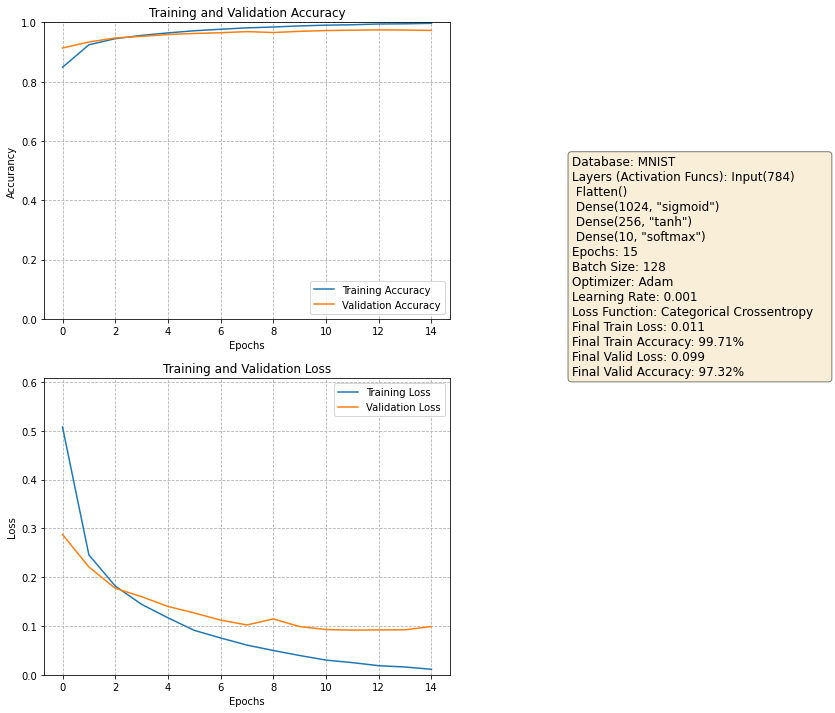

Database: MNIST     
Layers (Activation Funcs): Input(784)
 Flatten()
 Dense(1024, "sigmoid")
 Dense(256, "tanh")
 Dense(10, "softmax")     
Epochs: 15     
Batch Size: 128     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Categorical Crossentropy    
Final Train Loss: 0.011    
Final Train Accuracy: 99.71%    
Final Valid Loss: 0.099    
Final Valid Accuracy: 97.32%


In [13]:
layers=[f'Input({28*28})', f'Flatten()\n Dense({32*32}, "sigmoid")', f'Dense({16*16}, "tanh")', f'Dense({num_classes}, "softmax")']
print(plot_train_history(history, layers, epochs=epochs, batch_size=batch_size, 
                         learning_rate=0.001, optimizer_name='Adam', loss_function_name='Categorical Crossentropy', 
                         db_name='MNIST', img_dir='graphics', df=ALL_HISTORY))

In [14]:
model = Sequential()
model.add(InputLayer(input_shape=(input_shape)))
model.add(Flatten())
model.add(Dense(28*28, activation='relu'))
model.add(Dense(16*16, activation='sigmoid'))
model.add(Dense(10*10, activation='tanh'))
model.add(Dense(4*4, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3, verbose=0)

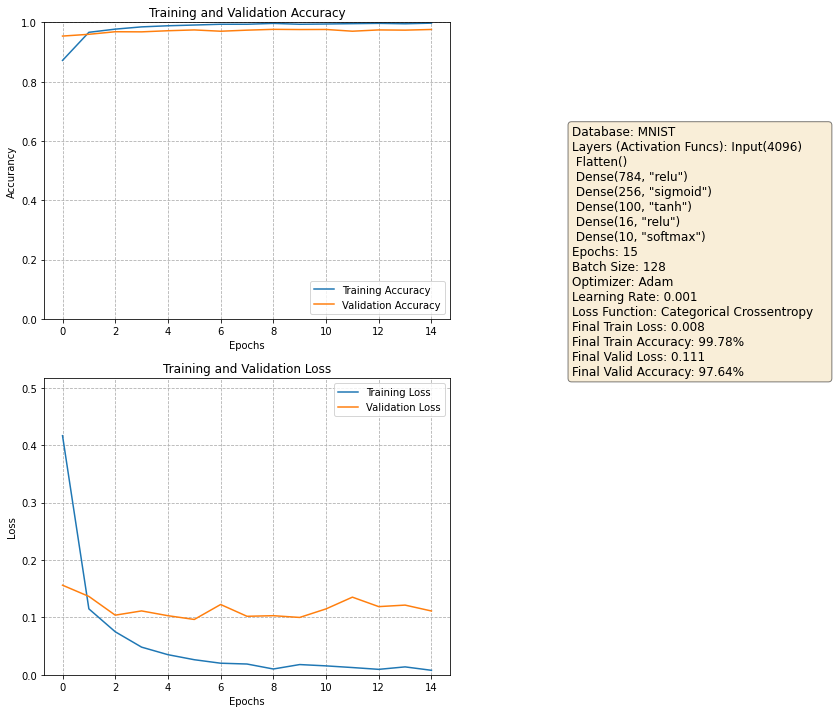

Database: MNIST     
Layers (Activation Funcs): Input(4096)
 Flatten()
 Dense(784, "relu")
 Dense(256, "sigmoid")
 Dense(100, "tanh")
 Dense(16, "relu")
 Dense(10, "softmax")     
Epochs: 15     
Batch Size: 128     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Categorical Crossentropy    
Final Train Loss: 0.008    
Final Train Accuracy: 99.78%    
Final Valid Loss: 0.111    
Final Valid Accuracy: 97.64%


In [15]:
layers=[f'Input({64*64})', f'Flatten()', f'Dense({28*28}, "relu")', f'Dense({16*16}, "sigmoid")', f'Dense({10*10}, "tanh")', f'Dense({4*4}, "relu")', f'Dense({num_classes}, "softmax")']
print(plot_train_history(history, layers, epochs=epochs, batch_size=batch_size, 
                         learning_rate=0.001, optimizer_name='Adam', loss_function_name='Categorical Crossentropy', 
                         db_name='MNIST', img_dir='graphics', df=ALL_HISTORY))

Вывод результатов обучения различных моделей полносвязных нейронныых сетей

In [16]:
ALL_HISTORY[:]

,Epoches,Batch Size,Layers,Optimizer,Learning Rate,Loss Function,Final Train Accuracy,Final Valid Accuracy,Final Train Loss,Final Valid Loss
0,15,128,"Input(784) Flatten() Dense(784, ""tanh"") Dense(...",Adam,0.001,Categorical Crossentropy,99.83%,97.65%,0.006,0.098
1,15,128,"Input(784) Flatten()\n Dense(784, ""relu"") Dens...",Adam,0.001,Categorical Crossentropy,99.74%,97.67%,0.008,0.118
2,15,128,"Input(784) Flatten()\n Dense(1024, ""sigmoid"") ...",Adam,0.001,Categorical Crossentropy,99.71%,97.32%,0.011,0.099
3,15,128,"Input(4096) Flatten() Dense(784, ""relu"") Dense...",Adam,0.001,Categorical Crossentropy,99.78%,97.64%,0.008,0.111


In [19]:
# архивирование папки с графиками
# !zip -r /content/graphics.zip /content/graphics

  adding: content/graphics/ (stored 0%)
  adding: content/graphics/NN Training MNIST. Epochs(15) Optim(Adam) LearningRate(0.001) LossFunc(Categorical Crossentropy) 3.png (deflated 10%)
  adding: content/graphics/NN Training MNIST. Epochs(15) Optim(Adam) LearningRate(0.001) LossFunc(Categorical Crossentropy) 2.png (deflated 10%)
  adding: content/graphics/NN Training MNIST. Epochs(15) Optim(Adam) LearningRate(0.001) LossFunc(Categorical Crossentropy) 1.png (deflated 10%)
  adding: content/graphics/NN Training MNIST. Epochs(15) Optim(Adam) LearningRate(0.001) LossFunc(Categorical Crossentropy) 4.png (deflated 10%)


In [20]:
# скачивание архива себе на ПК
# from google.colab import files
# files.download("/content/graphics.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>